In [17]:
# -*- coding: utf-8 -*-
import numpy as np
from matplotlib import pyplot as plt
from math import *
import seaborn as sns
from scipy.integrate import odeint
import numba
from numba import jit,complex128
import time
import random
mylen = np.vectorize(len)
%matplotlib inline

In [2]:
#For Figs. 5b and S21 in the paper 
#"Evolutionary transition from a single RNA replicator to a multiple replicator network"

In [18]:
#Replication
@jit(locals=dict(c=complex128, z=complex128)) #faster than Cython 
def replication_five_member(v0, t, k1s, k2s, k3s, k4s, k5s, Cn):
    dv = np.empty_like(v0)
    Capacity = (1-(v0[0]+v0[1]+v0[2]+v0[3]+v0[4])/Cn)
    dv[0]=v0[0]*(k1s[0]*v0[0] + k2s[0]*v0[1] + k3s[0]*v0[2] + k4s[0]*v0[3]+ k5s[0]*v0[4])*Capacity
    dv[1]=v0[1]*(k1s[1]*v0[0] + k2s[1]*v0[1] + k3s[1]*v0[2] + k4s[1]*v0[3]+ k5s[1]*v0[4])*Capacity
    dv[2]=v0[2]*(k1s[2]*v0[0] + k2s[2]*v0[1] + k3s[2]*v0[2] + k4s[2]*v0[3]+ k5s[2]*v0[4])*Capacity
    dv[3]=v0[3]*(k1s[3]*v0[0] + k2s[3]*v0[1] + k3s[3]*v0[2] + k4s[3]*v0[3]+ k5s[3]*v0[4])*Capacity
    dv[4]=v0[4]*(k1s[4]*v0[0] + k2s[4]*v0[1] + k3s[4]*v0[2] + k4s[4]*v0[3]+ k5s[4]*v0[4])*Capacity
    return dv

#Initial concentrations
def initial(M,H1i,H2i,H3i,P1i,P2i):
    comps = np.vstack([np.random.poisson(RNAi/float(M),M) for RNAi in [H1i,H2i,H3i,P1i,P2i]]) 
    return comps

#Dilution
def dilution(D,M,comps):
    np.random.shuffle(comps.T) #Randomization
    comps= comps[:,:int(M/D)] #Dilution
    newcomps = np.vstack([np.zeros(M-int(M/D)) for i in range(5)]) #New compartments
    comps = np.hstack([comps, newcomps]) #Combine
    return comps

#Repartition (Fusion-division)
def repartition(Fnumber, comps):
    X = list(range(M))
    ids = [random.sample(X, 2) for i in range(Fnumber)] #randomly choose two compartments x F sets
    for i in ids:
        p,q = i[0],i[1]
        if np.sum(comps[:,p]+comps[:,q])>0: #Other than a set of vacant compartments
            fuse = (comps[:,p] + comps[:,q]).astype(np.int32) #Fusion
            comps[0,p], comps[1,p], comps[2,p], comps[3,p], comps[4,p] = \
                np.random.binomial(fuse[0],0.5),np.random.binomial(fuse[1],0.5), np.random.binomial(fuse[2],0.5),\
                np.random.binomial(fuse[3],0.5), np.random.binomial(fuse[4],0.5) #Division 
            comps[:,q] = fuse - comps[:,p]
    return comps

In [19]:
#Serial transfer
kij = np.loadtxt('211017.csv', delimiter=',') #Fig. S23
k1s, k2s, k3s, k4s, k5s = kij[0], kij[1], kij[2], kij[3], kij[4] 
Round=100
M=300
Cn = 300 #C in the paper
D=5
Fnumber=int(M*1.3) #F in the paper
reaction_time = 2
IDs = np.array(['H1','H2','H3','P1','P2']) #each corresponds to HL1, HL2, HL3, PL2, and PL3
t = np.linspace(0, reaction_time, 2) 

for X in range(1):
    [H1i,H2i,H3i,P1i,P2i]=[M*10,M*10,M*10,M*10,M*10]
    H1s,H2s,H3s,P1s,P2s = [H1i],[H2i],[H3i],[P1i],[P2i]
    concs = [H1s,H2s,H3s,P1s,P2s]
    #transfer
    comps= initial(M,H1i,H2i,H3i,P1i,P2i)
    R_true = 0
    for R in range(Round):
        R_true+=1
        if np.sum(comps)>0: #only if a replicator is remaining
            if R != 0:
                comps = dilution(D,M,comps) #dilution
                comps = repartition(Fnumber, comps) #repartition
                active_comp_IDs = np.where(np.sum(comps,axis=0)>0)[0] #IDs of compartments containing molecules
                comps = np.hstack([comps[:,active_comp_IDs]]) #obtain compartments containing molecules
            #replication
            for k in range(len(comps[0])):
                RNAs = np.hstack([comps[j][k] for j in range(5)])
                v =  odeint(replication_five_member, RNAs, t, args=(k1s, k2s, k3s, k4s, k5s, Cn)) #律速
                for l in range(5):
                    comps[l][k]=int(v[-1][l])
            #return vacant compartments
            new = M-len(comps[0])
            comps = np.hstack([comps,np.zeros(new*5).reshape(5,new)])
        for i in range(5):
            concs[i].append(np.sum(comps[i])) 

    np.save('XXX.npy', np.array(concs))

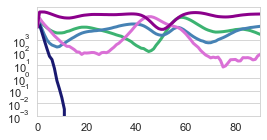

In [21]:
#Visualization
for k in range(1):
    concs = np.load('XXX.npy')
    concs2 = concs/M 
    R= len(concs2[0])-1
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(1,1,1)
    cs= ['mediumseagreen','steelblue','midnightblue','orchid','darkmagenta']
    for i in range(5):
        ax.plot(np.arange(R+1),concs2[i][:R+1], '-', label=IDs[i],c=cs[i], linewidth = 3)
    ax.grid(axis='x')
    ax.tick_params(axis='x', labelsize=11), ax.tick_params(axis='y', labelsize=11)
    ax.set_yscale('log')
    ax.set_xticks([0,20,40,60,80,100])
    ax.set_yticks([10**-3,10**-2,10**-1,1,10,100,1000])
    ax.set_xlim(0,90), ax.set_ylim(1/1000,)
    fig.savefig('XXX', dpi=600, bbox_inches='tight')